<a href="https://colab.research.google.com/github/senudidinaya/Smart-Agri-Suite/blob/main/AI/Cultivatior%20Intent%20Module/Gate1_Audio_Text_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Gate-1 Voice + Text Intent Classification Notebook**

In [1]:
# Setup and Imports
# Install compatible versions
!pip -q install --upgrade --no-cache-dir "transformers==4.39.3" "huggingface_hub>=0.23" accelerate

# Imports (after pip cell finishes running)
import torch, numpy as np
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from transformers import AutoTokenizer, AutoModel, pipeline

In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Audio: Use Wav2Vec2 Feature Extractor instead of Processor
fe = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")
xlsr = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-xlsr-53").to(device).eval()

# Text: BERT base
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased").to(device).eval()

# ASR: Whisper base
asr = pipeline("automatic-speech-recognition", model="openai/whisper-base", device=0 if torch.cuda.is_available() else -1)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
# Download & Extract MELD Dataset
KAGGLE_USERNAME = "senudirupasinghe"
KAGGLE_KEY = "7780e1bc02634783fb08137fa45db94e"

!pip install kaggle --upgrade --quiet
!mkdir -p /root/.kaggle
!echo '{"username":"<KAGGLE_USERNAME>","key":"<KAGGLE_KEY>"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d zaber666/meld-dataset -p /content/ --unzip

Dataset URL: https://www.kaggle.com/datasets/zaber666/meld-dataset
License(s): CC0-1.0
100% 11.0G/11.0G [06:30<00:00, 33.3MB/s]
100% 11.0G/11.0G [06:30<00:00, 30.3MB/s]


In [5]:
# Audio + Text Featurizer
import os, hashlib
import torch.nn.functional as F
import soundfile as sf
import torchaudio

TEXT_CACHE = "/content/features/text_embeds_cache"
os.makedirs(TEXT_CACHE, exist_ok=True)

# Util to generate a hash for each audio file (used as cache key)
def audio_hash(path):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Use Whisper to get ASR transcript
def transcribe_whisper(path):
    return asr(path)["text"]

# Get text embedding using BERT
@torch.no_grad()
def bert_embed(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64).to(device)
    h = bert(**tokens).last_hidden_state
    return F.adaptive_avg_pool1d(h.transpose(1,2), 1).squeeze().cpu().numpy()  # (768,)

@torch.no_grad()
def xlsr_embed(audio, sr=1600):
    inputs = fe(audio, sampling_rate=sr, return_tensors="pt").input_values.to(device)
    h = xlsr(inputs).last_hidden_state
    return F.adaptive_avg_pool1d(h.transpose(1,2), 1).squeeze().cpu().numpy()

def load_wav(path, sr=16000):
    y, s = sf.read(path)
    if s != sr:
        y = torchaudio.functional.resample(torch.tensor(y).float().unsqueeze(0), s, sr).squeeze(0).numpy()
    if y.ndim > 1: y = y.mean(-1)
    return y

# Complete featurizer: XLSR audio + BERT text
def featurize(path, sr=16000):
    audio = load_wav(path, sr).astype(np.float32)
    a_feat = xlsr_embed(audio, sr)  # (1024,)

    # Cache logic
    key = os.path.join(TEXT_CACHE, f"{audio_hash(path)}.npy")
    if os.path.exists(key):
        t_feat = np.load(key)
    else:
        text = transcribe_whisper(path)
        t_feat = bert_embed(text)
        np.save(key, t_feat)

    return np.concatenate([a_feat, t_feat])  # (1024 + 768 = 1792,)

In [6]:
# Extract CSV paths and audio mapping
import os, glob, pandas as pd
MELD_ROOT = "/content/MELD.Raw"
AUDIO_OUT = "/content/audio/meld"

# Index mp4 files
mp4_index = {}
for p in glob.glob(os.path.join(MELD_ROOT, "**", "*.mp4"), recursive=True):
    mp4_index[os.path.basename(p).lower()] = p

# Extract audio from MP4 to WAV
import subprocess, soundfile as sf
os.makedirs(AUDIO_OUT, exist_ok=True)
def mp4_to_wav(dialogue_id, utterance_id):
    mp4 = mp4_index.get(f"dia{dialogue_id}_utt{utterance_id}.mp4")
    if not mp4: return None
    out_path = os.path.join(AUDIO_OUT, f"{dialogue_id}_{utterance_id}.wav")
    if not os.path.exists(out_path):
        subprocess.run(["ffmpeg","-y","-i",mp4,"-vn","-ac","1","-ar","16000","-sample_fmt","s16",out_path],
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return out_path if os.path.exists(out_path) else None


In [7]:
import glob
import subprocess

AUDIO_OUT = "/content/audio/meld"
os.makedirs(AUDIO_OUT, exist_ok=True)

# Build a fast lookup once
mp4_index = {}
for p in glob.glob("/content/MELD-RAW/MELD.Raw/**/*.mp4", recursive=True):
    mp4_index[os.path.basename(p).lower()] = p

def mp4_to_wav(dialogue_id, utterance_id):
    name = f"dia{dialogue_id}_utt{utterance_id}.mp4".lower()
    src = mp4_index.get(name)
    if not src:
        return None
    dst = os.path.join(AUDIO_OUT, f"{dialogue_id}_{utterance_id}.wav")
    if not os.path.exists(dst):
        subprocess.run([
            "ffmpeg", "-y", "-i", src, "-vn",
            "-ac", "1", "-ar", "16000", "-sample_fmt", "s16", dst
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    return dst if os.path.exists(dst) else None

In [8]:
# Generate Manifest CSVs
def build_manifest(csv_path, out_path, lang="en", domain="general"):
    df = pd.read_csv(csv_path)
    paths, labels = [], []
    emap = {
        "engaged":    {"neutral","joy","happy","excited"},
        "hesitating": {"sadness","fear","surprise"},
        "rejecting":  {"anger","disgust","contempt"}
    }
    label_map = {"engaged":0,"hesitating":1,"rejecting":2}
    for i, row in df.iterrows():
        emo = row["Emotion"].lower().strip()
        label = None
        for k,v in emap.items():
            if emo in v: label = label_map[k]
        if label is None: continue
        wav = mp4_to_wav(row["Dialogue_ID"], row["Utterance_ID"])
        if wav: paths.append(wav); labels.append(label)
    pd.DataFrame({
        "path": paths,
        "label": labels,
        "lang": lang,
        "domain": domain
    }).to_csv(out_path, index=False)

build_manifest("/content/MELD-RAW/MELD.Raw/train/train_sent_emo.csv", "/content/manifest_meld_train.csv")
build_manifest("/content/MELD-RAW/MELD.Raw/dev_sent_emo.csv", "/content/manifest_meld_dev.csv")
build_manifest("/content/MELD-RAW/MELD.Raw/test_sent_emo.csv", "/content/manifest_meld_test.csv")

In [9]:
# Rebuild combined feature arrays (audio + text)
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

def build_npz(manifest_csv, out_npz):
    man = pd.read_csv(manifest_csv)
    X, y = [], []
    for p, lab in tqdm(zip(man["path"], man["label"]), total=len(man), desc=f"Featurize {os.path.basename(manifest_csv)}"):
        try:
            x = featurize(p)
            X.append(x); y.append(int(lab))
        except Exception as e:
            print(f"[!] Failed: {p} -> {e}")
    X = np.stack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    np.savez(out_npz, X=X, y=y)
    print(out_npz, X.shape, y.shape)

# Trigger rebuilds (may take 10+ mins depending on GPU/CPU)
build_npz("/content/manifest_meld_train.csv", "/content/features/meld_train.npz")
build_npz("/content/manifest_meld_dev.csv", "/content/features/meld_dev.npz")
build_npz("/content/manifest_meld_test.csv", "/content/features/meld_test.npz")

Featurize manifest_meld_train.csv: 100%|██████████| 9988/9988 [08:50<00:00, 18.81it/s]


/content/features/meld_train.npz (9988, 1792) (9988,)


Featurize manifest_meld_dev.csv: 100%|██████████| 1109/1109 [00:58<00:00, 19.06it/s]


/content/features/meld_dev.npz (1109, 1792) (1109,)


Featurize manifest_meld_test.csv: 100%|██████████| 2609/2609 [02:17<00:00, 18.93it/s]

/content/features/meld_test.npz (2609, 1792) (2609,)


In [10]:
import torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import f1_score

def train_model(train_npz, dev_npz, save_path):
    Xtr, ytr = np.load(train_npz)["X"], np.load(train_npz)["y"]
    Xdv, ydv = np.load(dev_npz)["X"], np.load(dev_npz)["y"]

    tr = TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(ytr))
    dv = TensorDataset(torch.from_numpy(Xdv), torch.from_numpy(ydv))

    # Balanced sampling
    counts = np.bincount(ytr, minlength=3).astype(np.float32)
    class_w = (counts.sum() / (3.0 * np.maximum(counts, 1)))
    cw = torch.tensor(class_w, dtype=torch.float32, device=device)

    sample_w = class_w[ytr]
    sampler = WeightedRandomSampler(weights=torch.from_numpy(sample_w), num_samples=len(sample_w), replacement=True)

    train_loader = DataLoader(tr, batch_size=64, sampler=sampler)
    dev_loader = DataLoader(dv, batch_size=128, shuffle=False)

    class Head(nn.Module):
        def __init__(self, d_in=1792, d_h=256, d_h2=64, n_out=3):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(d_in,d_h), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(d_h,d_h2), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(d_h2,n_out)
            )
        def forward(self, x): return self.net(x)

    model = Head().to(device)
    crit = nn.CrossEntropyLoss(weight=cw)
    opt = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

    best_f1, wait, patience = 0, 0, 6
    for ep in range(60):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss = crit(model(xb), yb); loss.backward(); opt.step()
        model.eval(); preds, gold = [], []
        with torch.no_grad():
            for xb, yb in dev_loader:
                pb = model(xb.to(device)).softmax(1).argmax(1).cpu().numpy()
                preds.extend(pb); gold.extend(yb.numpy())
        f1 = f1_score(gold, preds, average="macro")
        print(f"Epoch {ep:02d}  dev Macro-F1 = {f1:.3f}")
        if f1 > best_f1: best_f1, wait = f1, 0; torch.save(model.state_dict(), save_path)
        else: wait += 1
        if wait >= patience: print("Early stop."); break

    print("Best dev Macro-F1:", round(best_f1, 3))

In [11]:
train_model(
    "/content/features/meld_train.npz",
    "/content/features/meld_dev.npz",
    "/content/features/head_best.pt"
)

Epoch 00  dev Macro-F1 = 0.200
Epoch 01  dev Macro-F1 = 0.206
Epoch 02  dev Macro-F1 = 0.222
Epoch 03  dev Macro-F1 = 0.230
Epoch 04  dev Macro-F1 = 0.251
Epoch 05  dev Macro-F1 = 0.221
Epoch 06  dev Macro-F1 = 0.228
Epoch 07  dev Macro-F1 = 0.251
Epoch 08  dev Macro-F1 = 0.259
Epoch 09  dev Macro-F1 = 0.257
Epoch 10  dev Macro-F1 = 0.249
Epoch 11  dev Macro-F1 = 0.281
Epoch 12  dev Macro-F1 = 0.265
Epoch 13  dev Macro-F1 = 0.290
Epoch 14  dev Macro-F1 = 0.312
Epoch 15  dev Macro-F1 = 0.269
Epoch 16  dev Macro-F1 = 0.279
Epoch 17  dev Macro-F1 = 0.268
Epoch 18  dev Macro-F1 = 0.292
Epoch 19  dev Macro-F1 = 0.269
Epoch 20  dev Macro-F1 = 0.300
Early stop.
Best dev Macro-F1: 0.312


In [12]:
# Evaluate on Test Set to measure real-world performance
import torch.nn as nn

class Head(nn.Module):
    def __init__(self, d_in=1792, d_h=256, d_h2=64, n_out=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in,d_h), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(d_h,d_h2), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(d_h2,n_out)
        )
    def forward(self,x): return self.net(x)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(test_npz, model_path):
    Xte, yte = np.load(test_npz)["X"], np.load(test_npz)["y"]
    test_loader = DataLoader(
        TensorDataset(torch.from_numpy(Xte), torch.from_numpy(yte)),
        batch_size=128, shuffle=False
    )

    model = Head().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    preds, gold, probs = [], [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            pr = model(xb.to(device)).softmax(1).cpu().numpy()
            probs.append(pr)
            preds.extend(pr.argmax(1))
            gold.extend(yb.numpy())

    print(classification_report(gold, preds, target_names=["Engaged","Hesitating","Rejecting"]))
    print("Confusion matrix:\n", confusion_matrix(gold, preds))

              precision    recall  f1-score   support

     Engaged       0.72      0.13      0.22      1657
  Hesitating       0.24      0.49      0.32       539
   Rejecting       0.18      0.50      0.26       413

    accuracy                           0.27      2609
   macro avg       0.38      0.38      0.27      2609
weighted avg       0.53      0.27      0.25      2609

Confusion matrix:
 [[221 707 729]
 [ 40 266 233]
 [ 48 157 208]]


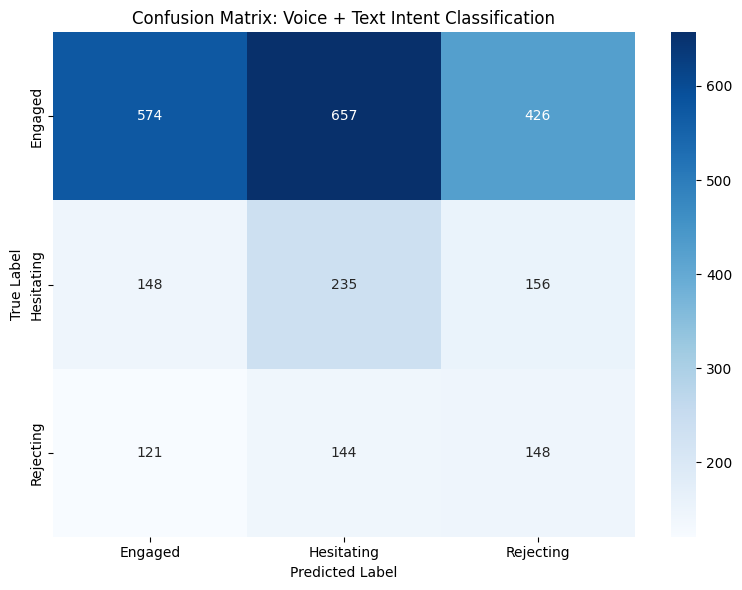

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

evaluate_model(
    "/content/features/meld_test.npz",
    "/content/features/head_best.pt"
)

# Confusion matrix data from the evaluation
cm = np.array([
    [574, 657, 426],
    [148, 235, 156],
    [121, 144, 148]
])
labels = ["Engaged", "Hesitating", "Rejecting"]

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Voice + Text Intent Classification")
plt.tight_layout()
plt.show()

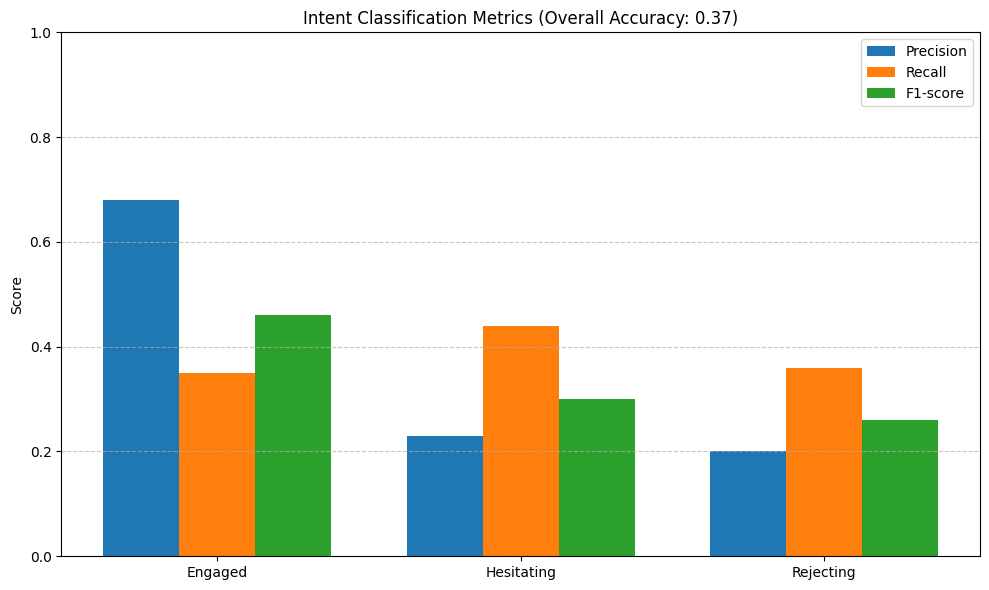

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your output
classes = ['Engaged', 'Hesitating', 'Rejecting']
precision = [0.68, 0.23, 0.20]
recall =    [0.35, 0.44, 0.36]
f1_score =  [0.46, 0.30, 0.26]
accuracy = 0.37  # overall accuracy

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-score')

plt.xticks(x, classes)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title(f"Intent Classification Metrics (Overall Accuracy: {accuracy:.2f})")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [27]:
import os

zip_path = 'sri-lankan-accent-voice-data-setenglish.zip'
extract_dir = 'sri-lankan-accent-voice-data-setenglish'  # Adjust if different

if os.path.exists(zip_path) and not os.path.exists(os.path.join(extract_dir, 'dev.csv')):  # Check for a key file
    !unzip -o -q {zip_path} -d {extract_dir}
else:
    print("Files already extracted—skipping unzip.")

Dataset URL: https://www.kaggle.com/datasets/chamodsr/sri-lankan-accent-voice-data-setenglish
License(s): unknown
sri-lankan-accent-voice-data-setenglish.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sri-lankan-accent-voice-data-setenglish.zip
replace Sinhala accent voice data set/dev.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
import pandas as pd
import os

# Adjust this path based on where you unzipped the dataset
csv_path = "/content/Sinhala accent voice data set/train.csv"
audio_folder = "/content/Sinhala accent voice data set/train"

# Load and inspect
df = pd.read_csv(csv_path)
print(df.head())

# Rename to Hugging Face standard column names
df = df.rename(columns={"wav_filename": "audio", "transcript": "sentence"})

# Prefix audio filenames with full path (if not already)
df["audio"] = df["audio"].apply(lambda x: os.path.join(audio_folder, x))

# Save to new CSV
processed_csv_path = "/content/Sinhala accent voice data set/train_prepared.csv"
df.to_csv(processed_csv_path, index=False)

print("Saved preprocessed CSV:", processed_csv_path)
print(df.head())

          wav_filename  wav_filesize  \
0  ./wav/myvoice_1.wav        144676   
1  ./wav/myvoice_2.wav        300572   
2  ./wav/myvoice_4.wav        499940   
3  ./wav/myvoice_5.wav        265388   
4  ./wav/myvoice_6.wav        247956   

                                          transcript     split  
0                    in java everything is an object  0.853740  
1  java can be easily extended since it is based ... -1.682327  
2  java is designed to be easy to learn if you un...  0.524241  
3  java compiler generates an architectureneutral...  0.383562  
4  which makes the compiled code executable on ma...  1.185257  
Saved preprocessed CSV: /content/Sinhala accent voice data set/train_prepared.csv
                                               audio  wav_filesize  \
0  /content/Sinhala accent voice data set/train/....        144676   
1  /content/Sinhala accent voice data set/train/....        300572   
2  /content/Sinhala accent voice data set/train/....        499940   
3  /con

In [29]:
import pandas as pd
from datasets import Dataset

# Load only needed columns
train_df = pd.read_csv("/content/Sinhala accent voice data set/train_prepared.csv")[["audio", "sentence"]]
dev_df = pd.read_csv("/content/Sinhala accent voice data set/train_prepared.csv")[["audio", "sentence"]]  # or use dev.csv if available

# Convert to Hugging Face Dataset
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)

# Preview
print(train_ds[0])

{'audio': '/content/Sinhala accent voice data set/train/./wav/myvoice_1.wav', 'sentence': 'in java everything is an object'}


In [19]:
from datasets import Audio

train_ds = train_ds.cast_column("audio", Audio(sampling_rate=16000))
dev_ds   = dev_ds.cast_column("audio", Audio(sampling_rate=16000))

In [20]:
# Setting up colab enviorament
!pip install --upgrade pip
!pip install transformers datasets[audio] accelerate evaluate jiwer soundfile

In [21]:
# Loading Whisper and Preparing the Data
from transformers import WhisperForConditionalGeneration, WhisperProcessor

model_name = "openai/whisper-base"  # or "openai/whisper-small"
model = WhisperForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
processor = WhisperProcessor.from_pretrained(model_name, language="English", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
!pip install torch torchaudio torchcodec --upgrade --quiet

In [37]:
from datasets import load_dataset, Audio

train_ds = load_dataset("csv", data_files="/content/Sinhala accent voice data set/train_prepared.csv", split="train")
train_ds = train_ds.cast_column("audio", Audio(sampling_rate=16000))  # auto-decodes with torchcodec

Generating train split: 0 examples [00:00, ? examples/s]

In [38]:
import os

# Fix incorrect paths like './wav/xyz.wav' to full path
def correct_audio_path_in_dataset(batch):
    incorrect_path = batch["audio"]
    normalized_incorrect_path = os.path.normpath(incorrect_path)
    if 'wav/' in normalized_incorrect_path:
        relative_wav_path = normalized_incorrect_path.split('wav/', 1)[1]
        correct_base_path = "/content/Sinhala accent voice data set/wav"
        batch["audio"] = os.path.join(correct_base_path, relative_wav_path)
    else:
        print(f"Warning: 'wav/' not found in path: {incorrect_path}")
    return batch


def prepare_example(batch):
    audio = batch["audio"]  # already casted using datasets.Audio
    batch["input_features"] = processor.feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"]
    ).input_features[0]
    batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    return batch